In [ ]:
###################################Time series charts############################################

In [2]:
import ee
ee.Authenticate()

True

In [3]:
#### connecting to my EEG cloud project account
ee.Initialize(project='emmanuella-gee-project')

In [4]:
import geemap, ee

In [5]:
 import seaborn as sns

In [6]:
import matplotlib.pyplot as plt

In [16]:
import json

In [17]:
import pandas as pd

In [34]:
import numpy as np

In [7]:
# identify a 500 meter buffer around our Point Of Interest (POI)
poi = ee.Geometry.Point(127.072483, 37.515817).buffer(500)

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2014-01-01','2020-5-31')

In [ ]:
###########Extracting all image values in the collection

In [8]:
def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

In [9]:
poi_reduced_imgs = viirs.map(poi_mean)

In [14]:
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [18]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

In [19]:
df

,date,mean
0,2014-01-01T00:00:00,61.927905
1,2014-02-01T00:00:00,51.591837
2,2014-03-01T00:00:00,51.378309
3,2014-04-01T00:00:00,59.228776
4,2014-05-01T00:00:00,63.510432
...,...,...
72,2020-01-01T00:00:00,44.474762
73,2020-02-01T00:00:00,38.256775
74,2020-03-01T00:00:00,46.065028
75,2020-04-01T00:00:00,45.411734


In [20]:
df['date'] = pd.to_datetime(df['date'])

df = df.set_index('date')

df

,mean
date,
2014-01-01,61.927905
2014-02-01,51.591837
2014-03-01,51.378309
2014-04-01,59.228776
2014-05-01,63.510432
...,...
2020-01-01,44.474762
2020-02-01,38.256775
2020-03-01,46.065028


In [ ]:
###Creating a time series graph for VIIRS-DNB from Jan 2014 to May 2020 for Seoul Olympic Stadium

In [21]:
####our study area
koreaMap = geemap.Map()
koreaMap.centerObject(poi, zoom=13)
koreaMap.add_basemap("SATELLITE")
koreaMap.addLayer(poi, {}, "Seoul Olympic Stadium")
koreaMap.addLayerControl()
koreaMap

Map(center=[37.5158175129507, 127.07248301794745], controls=(WidgetControl(options=['position', 'transparent_b…

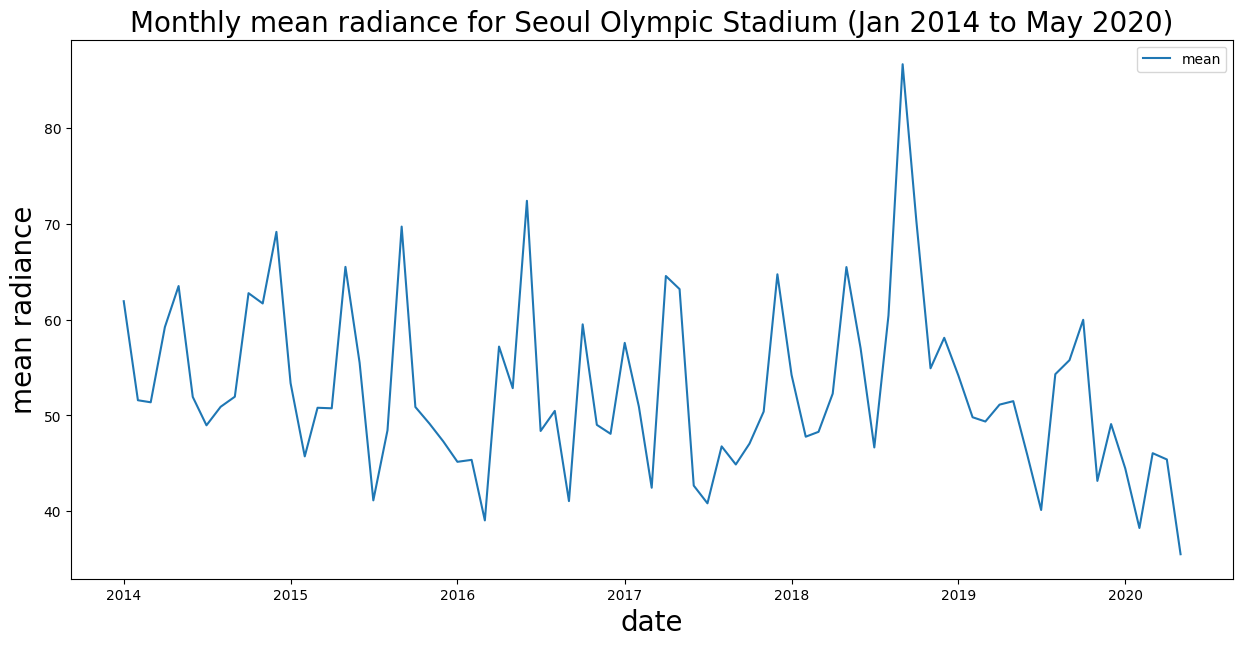

In [24]:
# we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# we'll create the plot by setting our dataframe to the data argument
sns.lineplot(data=df, ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title('Monthly mean radiance for Seoul Olympic Stadium (Jan 2014 to May 2020)',fontsize=20);

In [25]:
df.idxmax()

mean   2018-09-01
dtype: datetime64[ns]

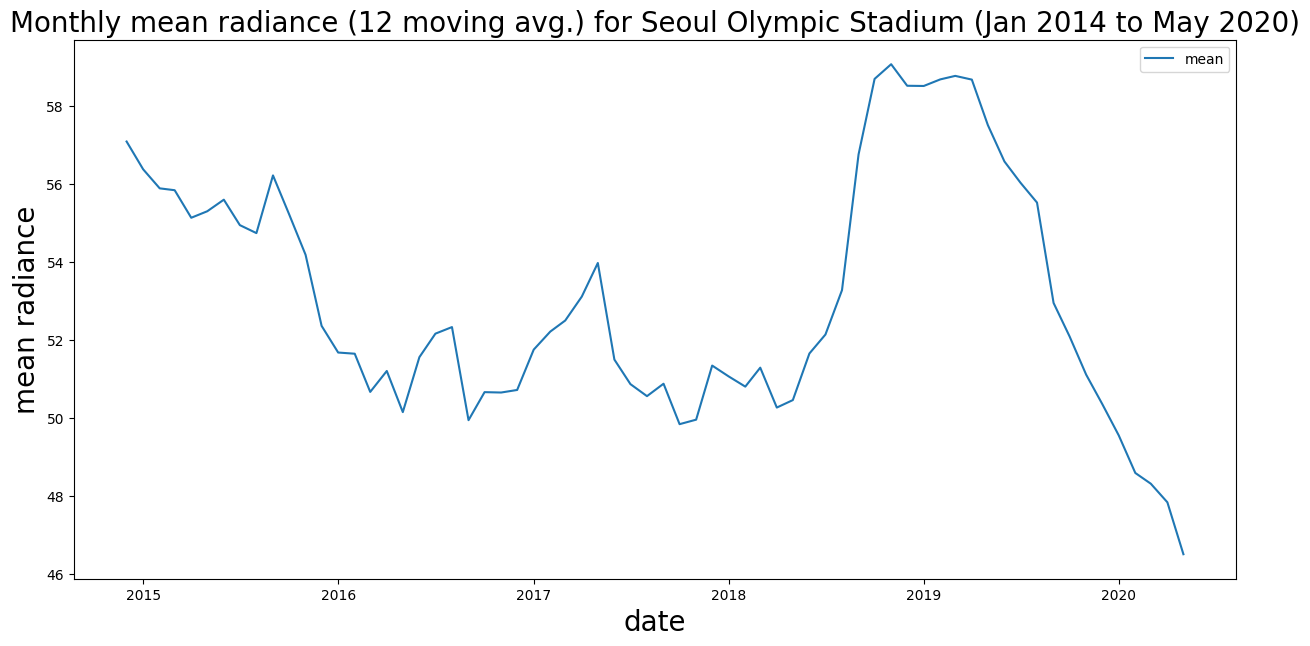

In [26]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=df.rolling(window).mean(), ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean radiance ({window} moving avg.) for Seoul Olympic Stadium (Jan 2014 to May 2020)',fontsize=20);

In [ ]:
###Time series using Sum Of Lights from Jan 2014 to May 2020 for South Korea

In [27]:
# get South Korea national boundary geometry
sokorea = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Republic of Korea')).first()).geometry()

# revise our reducer function to be to get SOL for South Korea
def get_sokorea_sol(img):
    sol = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=sokorea, scale=500, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('SOL',sol)

In [28]:
# reduce collection
sokorea_sol = viirs.map(get_sokorea_sol)

# get lists
nested_list = sokorea_sol.reduceColumns(ee.Reducer.toList(2), ['date','SOL']).values().get(0)

# convert to dataframe
soldf = pd.DataFrame(nested_list.getInfo(), columns=['date','SOL'])
soldf['date'] = pd.to_datetime(soldf['date'])
soldf = soldf.set_index('date')

In [29]:
koreaMap2 = geemap.Map()
koreaMap2.centerObject(sokorea, zoom=7)
koreaMap2.add_basemap("SATELLITE")
koreaMap2.addLayer(sokorea, {}, "South Korea")
koreaMap2.addLayer(viirs.select('avg_rad').median(), {'min':0,'max':10}, "VIIRS 2014-2020 mean")
koreaMap2.addLayerControl()
koreaMap2

Map(center=[36.344492190008246, 127.80177597242078], controls=(WidgetControl(options=['position', 'transparent…

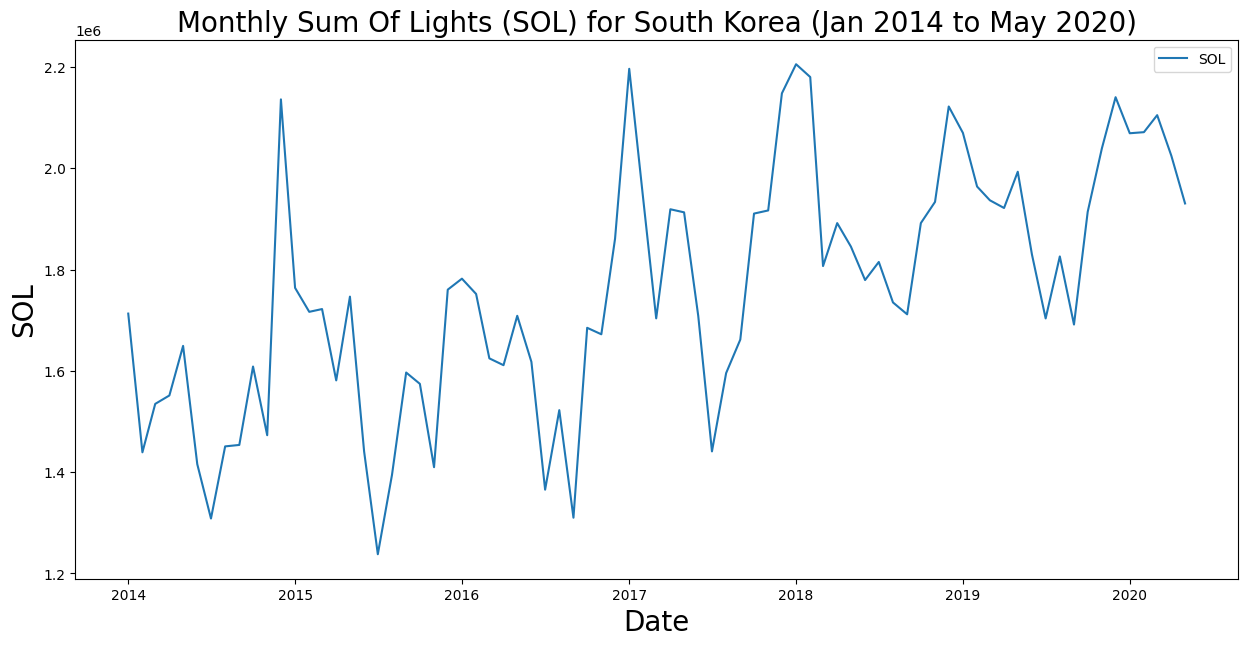

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=soldf, ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Monthly Sum Of Lights (SOL) for South Korea (Jan 2014 to May 2020)',fontsize=20);

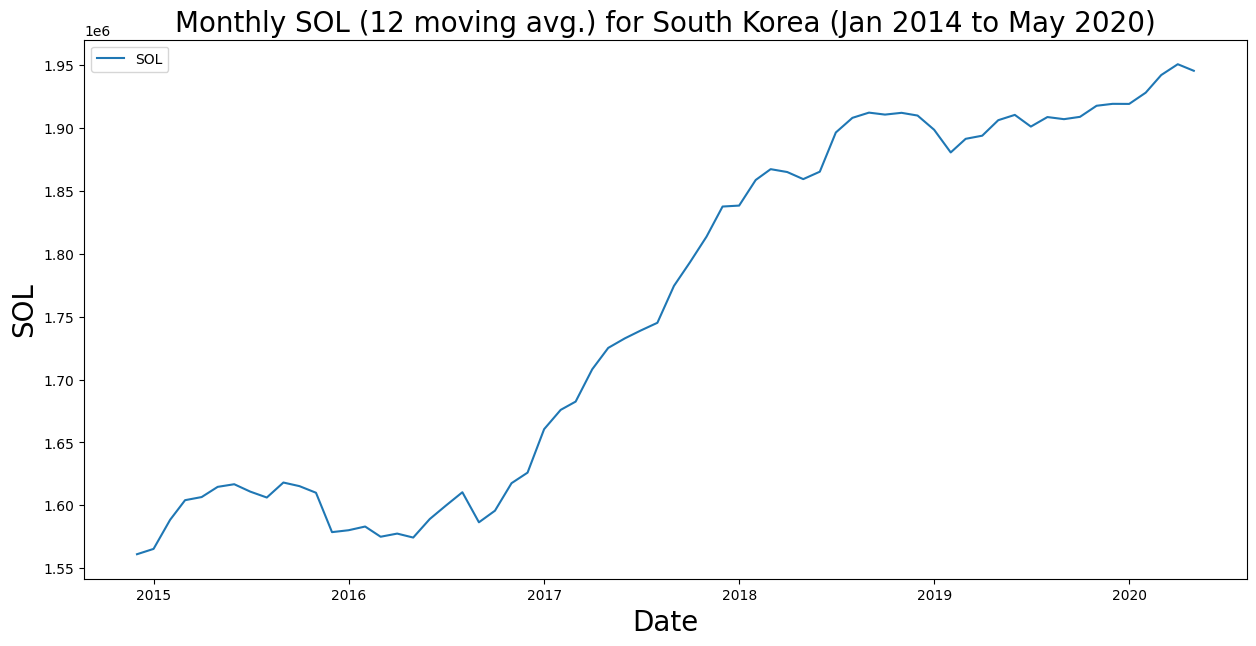

In [31]:
fig, ax = plt.subplots(figsize=(15,7))
window=12
sns.lineplot(data=soldf.rolling(window).mean(), ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Monthly SOL ({window} moving avg.) for South Korea (Jan 2014 to May 2020)',fontsize=20);

In [32]:
 #defining the region Berlin
berlin = ee.Feature(ee.FeatureCollection(
    "FAO/GAUL_SIMPLIFIED_500m/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Berlin')).first()).geometry()

# viirs for December 2019
viirsDec2019 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2019-12-01','2019-12-31').select('avg_rad').first()

berlinMap = geemap.Map()
berlinMap.centerObject(berlin, zoom=10)
berlinMap.addLayer(viirsDec2019.clip(berlin), {'min':1,'max':20}, opacity=.6)
berlinMap

Map(center=[52.503080254438004, 13.39870699912187], controls=(WidgetControl(options=['position', 'transparent_…

In [35]:
dec19arr = np.array(viirsDec2019.sampleRectangle(region=berlin).get('avg_rad').getInfo())

In [ ]:
####Ploting histogram############################################

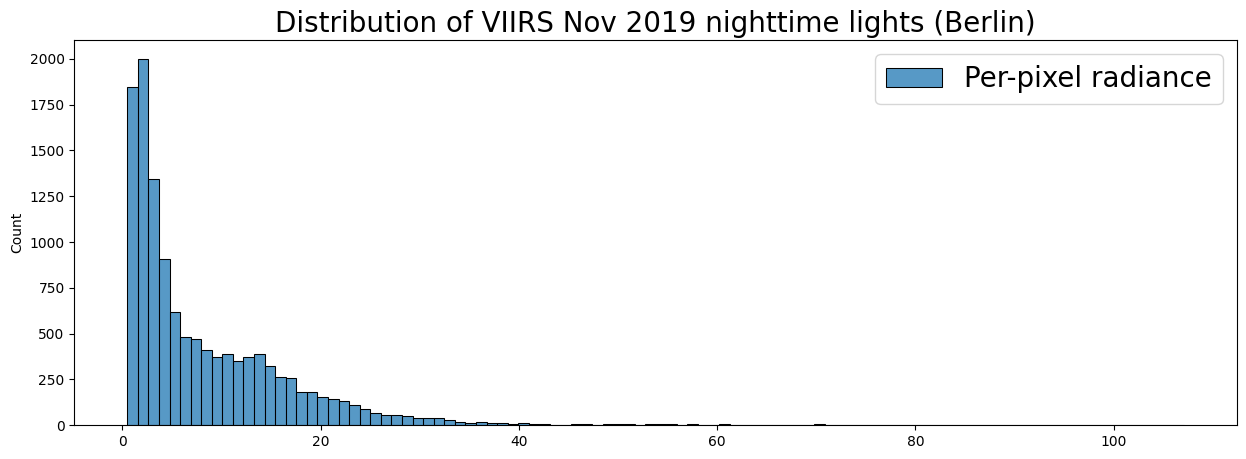

In [36]:
# first, we flatten our array to a 1-d array for the plot
data = dec19arr.flatten()

fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data, bins=100, label='Per-pixel radiance',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Nov 2019 nighttime lights (Berlin)', fontsize=20);

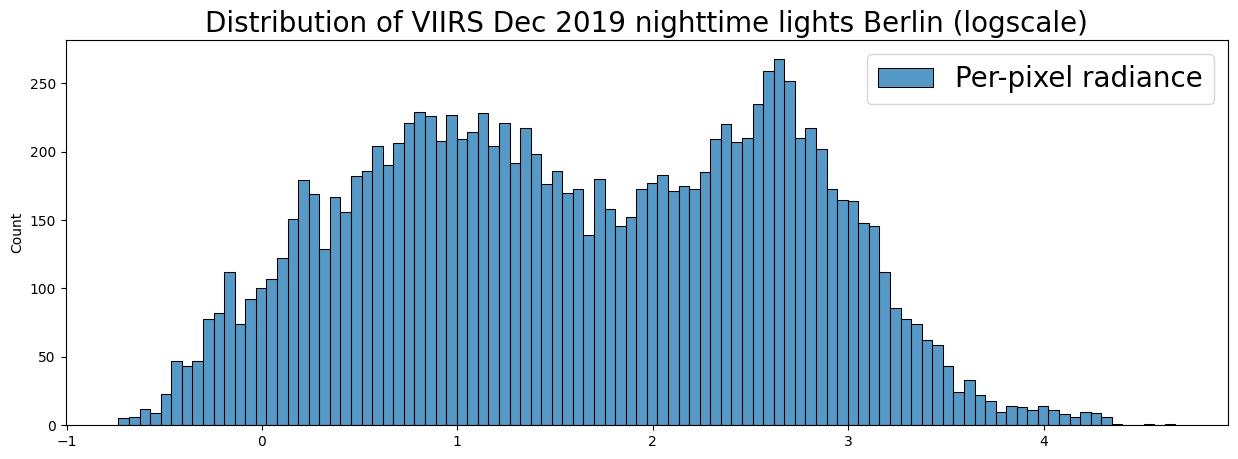

In [37]:
# logscale the data
data = np.log(dec19arr).flatten()

fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data, bins=100, label='Per-pixel radiance',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Dec 2019 nighttime lights Berlin (logscale)', fontsize=20);

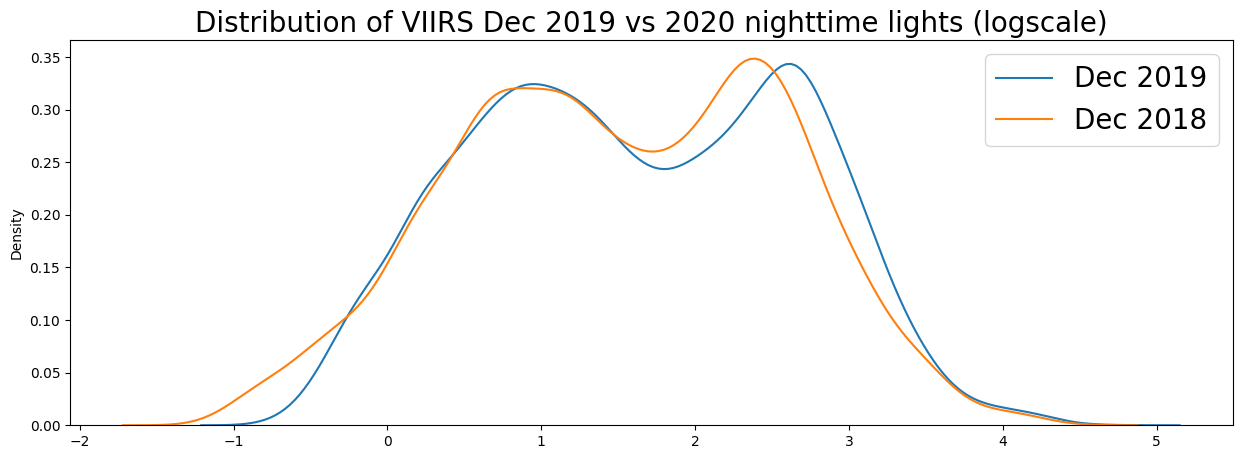

In [38]:
viirsDec18 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2018-12-01','2018-12-31').select('avg_rad').first()

dec18arr = np.array(viirsDec18.sampleRectangle(region=berlin).get('avg_rad').getInfo())

fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(np.log(dec19arr).flatten(), label='Dec 2019',legend=True, ax=ax)
sns.kdeplot(np.log(dec18arr).flatten(), label='Dec 2018',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Dec 2019 vs 2020 nighttime lights (logscale)', fontsize=20);

In [39]:
############Histogram of DMSP-OLS for Berlin in 2013############
# get annual composites for 2013, stable lights
dmsp13 = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS").filterDate('2013-01-01','2013-12-31').select('stable_lights').first()

# extract data to array
arr13 = np.array(dmsp13.sampleRectangle(region=berlin).get('stable_lights').getInfo())

In [40]:
berlinMap2 = geemap.Map()
berlinMap2.centerObject(berlin, zoom=10)
berlinMap2.addLayer(dmsp13.clip(berlin), {'min':0,'max':63}, opacity=.6)
berlinMap2

Map(center=[52.503080254438004, 13.39870699912187], controls=(WidgetControl(options=['position', 'transparent_…

In [41]:
print(f'VIIRS-DNB composite for Berlin has {dec19arr.size} datapoints')
print(f'DMSP-OLS composite for Berlin has {arr13.size} datapoints')

VIIRS-DNB composite for Berlin has 12400 datapoints
DMSP-OLS composite for Berlin has 3120 datapoints


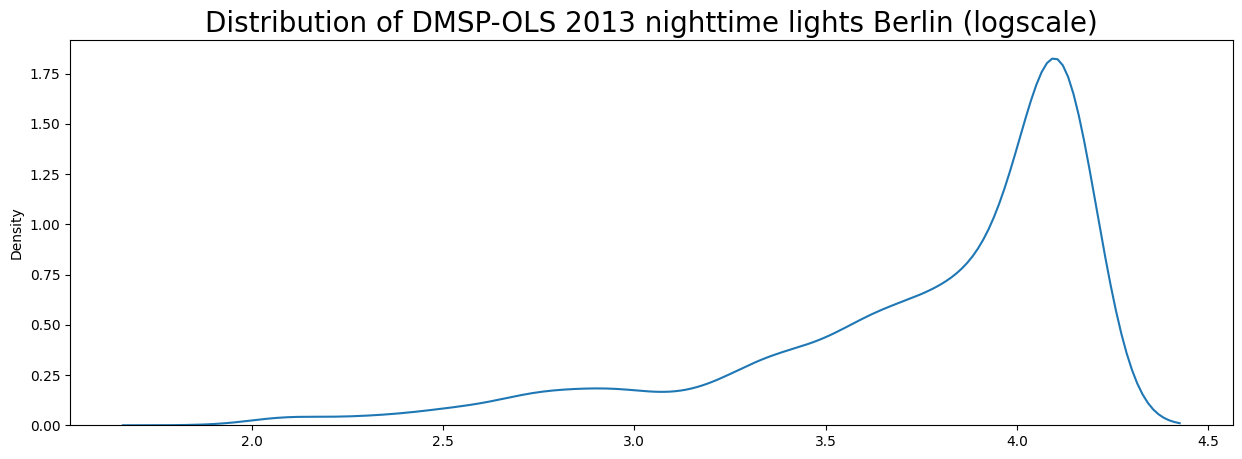

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(np.log(arr13).flatten(), legend=False, ax=ax)
plt.title('Distribution of DMSP-OLS 2013 nighttime lights Berlin (logscale)', fontsize=20);